In [11]:
import pandas as pd
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense

In [12]:
#Load the data we exported in the previous step
df = pd.read_csv('Machine_Learning_Data.csv')
df.drop(columns='Unnamed: 0', inplace=True)

#Load the ID & Name list
id_name_list = pd.read_csv('id_name_list.csv')

#### Linear Regression

Linear Regression is the most simple model and will be used as a baseline for comparison against the other models

Mean Absolute Error: 0.15789095275781456
Root Mean Squared Error: 0.29620255554303127
R-Squared: 0.9005556519594131


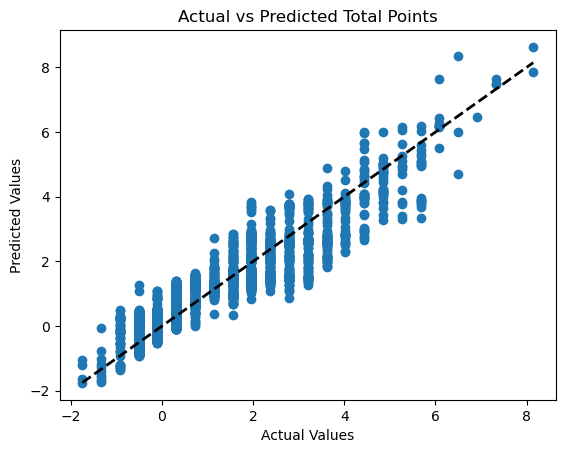

In [13]:
#Define features and target
X = df.drop(['total_points', 'ID'], axis=1)
y = df['total_points']

#Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, # 80-20 split as per Literature Review
                                                    shuffle=False) # No shuffle due to time-series nature

#Create a Linear Regression model
model = LinearRegression()

#Train the model
model.fit(X_train, y_train)

#Use the model to make predictions
y_pred = model.predict(X_test)

#Print Mean Absolute Error, Root Mean Squared Error and R-Squared values
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))

#Plot actual vs predicted values
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Total Points')
plt.show()


In [14]:
#Checking the ID for Kevin De Bruyne
#We will use him to check the outputs from our models
id_name_list[id_name_list['1']=='Kevin De Bruyne']

,0,1
491,491,Kevin De Bruyne


In [15]:
#Function to predict total_points given an ID
def predict_total_points(ID):
    features = df[df['ID'] == ID].drop(['total_points', 'ID'], axis=1)
    prediction = model.predict(features)
    return prediction

#Test the point prediction
ID = input("Enter an ID: ") #
print(f"The predicted total points for ID {ID} is: {sum(predict_total_points(int(ID)))}")

Enter an ID: 491
The predicted total points for ID 491 is: 160.50617012660177


We can see a very clear pattern to the errors from our plot, suggesting the model is not very good, furthermore when we test the total points for a strong player like KDB we can see it is some 23 points off the actual for the season (183)

#### Random Forests

These are our next level of complexity, still relatively easy to understand and interpret

Random Forest: Performance for split 1:
MAE: 0.1091519508828542
RMSE: 0.2710528751916312
R-Squared: 0.9282721626079293


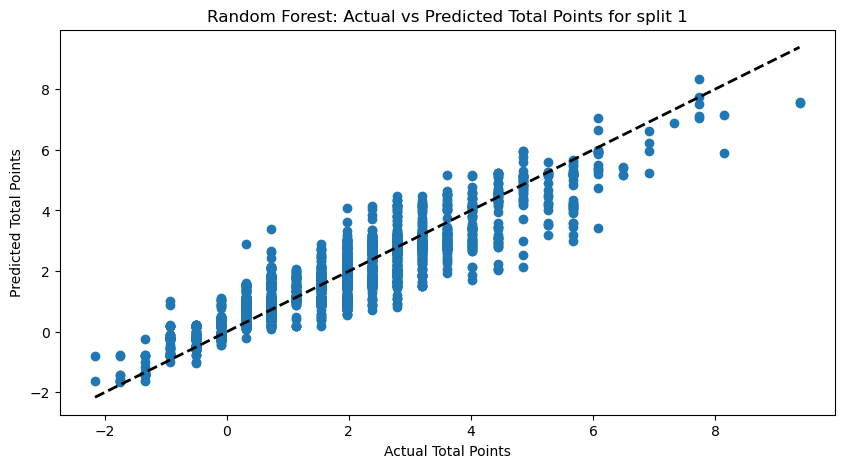

Random Forest: Performance for split 2:
MAE: 0.11098165674306106
RMSE: 0.2880560078036243
R-Squared: 0.9176159475069029


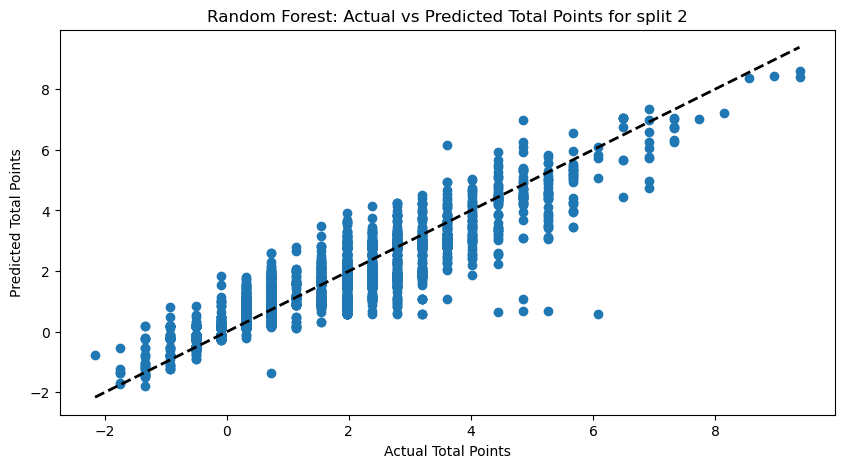

Random Forest: Performance for split 3:
MAE: 0.09590413773018076
RMSE: 0.2516119266455152
R-Squared: 0.929807220736018


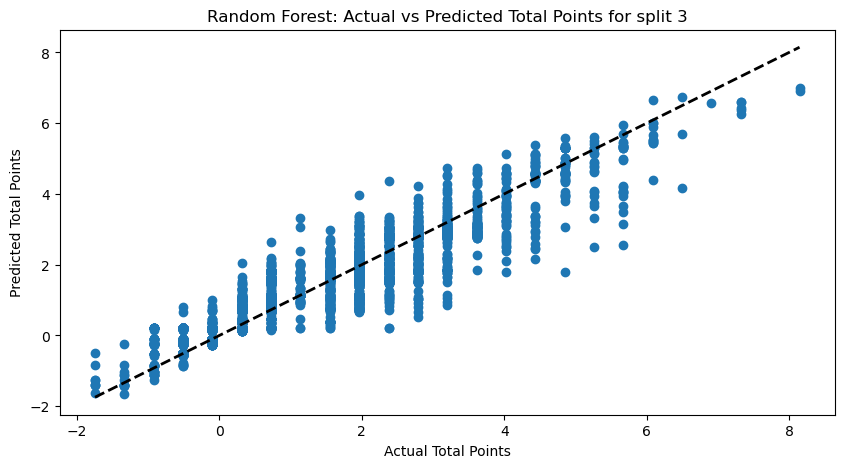

In [6]:
# Features and target variable
X = df.drop(['total_points', 'ID'], axis=1)
y = df['total_points']

# Hyperparameters for Grid Search
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': range(3, 10),
    'min_samples_split': [2, 5, 10]
}

# Initialize Random Forest and TimeSeriesSplit
model = RandomForestRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=3) # Representing 3 seasons of data gathered

# To store the best models from each split
best_models = []

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Grid Search for hyperparameter tuning
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models.append(grid_search.best_estimator_)
    
    # Predictions and Evaluation for the current split
    y_pred = grid_search.best_estimator_.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f'Random Forest: Performance for split {i+1}:')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R-Squared: {r2}')
    
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Total Points')
    plt.ylabel('Predicted Total Points')
    plt.title(f'Random Forest: Actual vs Predicted Total Points for split {i+1}')
    plt.show()

In [7]:
#Function to predict points based on a chosen model
def predict_total_points(ID, chosen_model):
    features = df[df['ID'] == ID].drop(['total_points', 'ID'], axis=1)
    prediction = chosen_model.predict(features)
    return prediction

#Test the point prediction
ID = input("Enter an ID: ")
chosen_model = best_models[2] #Using the last model as an example.
print(f"The predicted total points for ID {ID} is: {sum(predict_total_points(int(ID), chosen_model))}")

Enter an ID: 491
The predicted total points for ID 491 is: 159.90906264802004


Unfortunately we still see considerable pattern to the errors, suggesting the model is not very good, however when we test the total points for KDB we see a small increase, closer to the actual points for the season (183)

#### Gradient Boosting Machine Learning: XGBoost

Another step further into complexity, as per my Methodology this is the next step in our process before we finish with Deep Learning Models.

XGBoost Performance for split 1:
MAE: 0.11401388937630116
RMSE: 0.2679420106214926
R-Squared: 0.9299091504327288


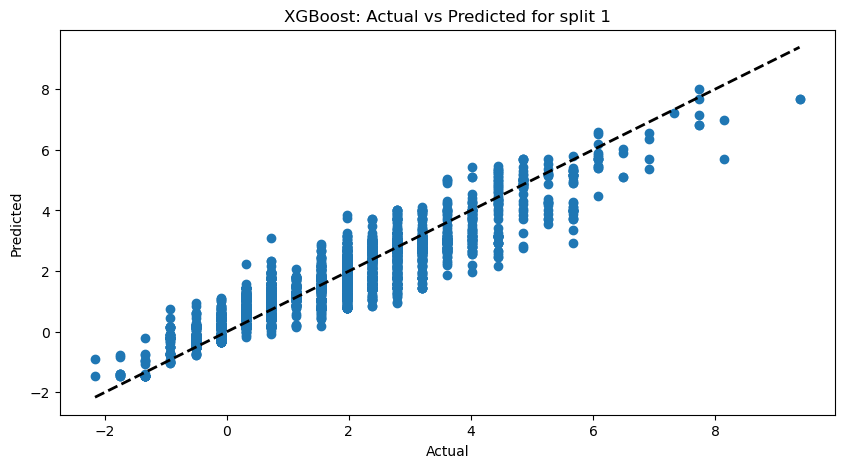

XGBoost Performance for split 2:
MAE: 0.11142549084893479
RMSE: 0.28166090726886267
R-Squared: 0.92123334111201


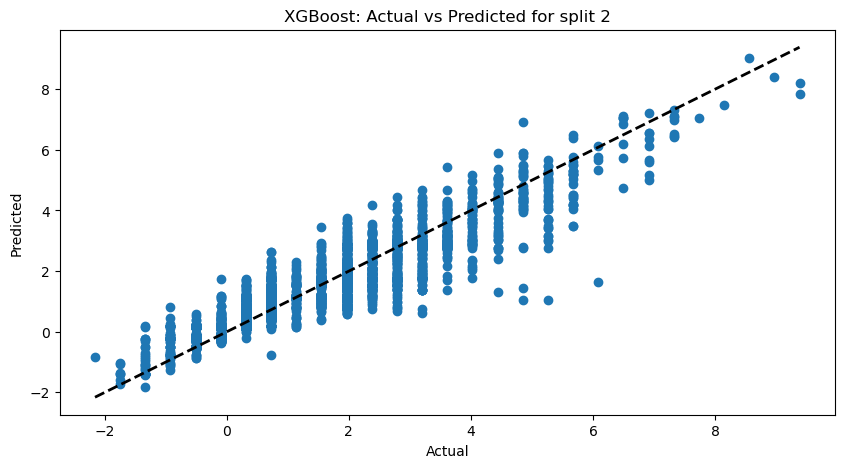

XGBoost Performance for split 3:
MAE: 0.09614109368378154
RMSE: 0.24525349034238694
R-Squared: 0.9333100509487479


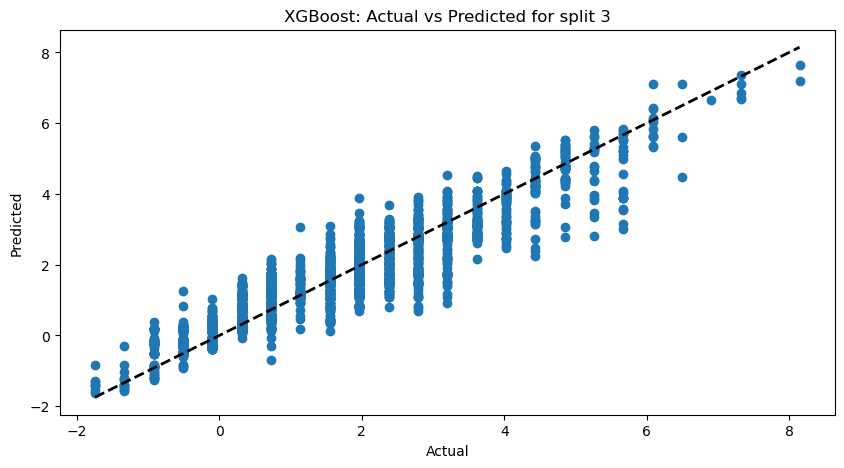

In [8]:
# Define features and target
X = df.drop(['total_points', 'ID'], axis=1)
y = df['total_points']

# Define models and parameters
model = XGBRegressor(random_state=42)
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': range(3, 10),
    'learning_rate': [0.01, 0.1, 0.2]
}

# TimeSeriesSplit for walk-forward validation
tscv = TimeSeriesSplit(n_splits=3)  # Representing 3 seasons of data gathered

# Initialize list for storing the best models
best_models = []

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Grid search to find optimal parameters
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1)  # Use 5-fold CV for the grid search
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Store the best model
    best_models.append(best_model)

    # Model Evaluation
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f'XGBoost Performance for split {i+1}:')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R-Squared: {r2}')

    # Plotting real vs predicted values
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'XGBoost: Actual vs Predicted for split {i+1}')
    plt.show()

#Access models with best_models[0], best_models[1], best_models[2]

In [9]:
#Test the point prediction
ID = input("Enter an ID: ")
chosen_model = best_models[2] #Using the last model as an example.
print(f"The predicted total points for ID {ID} is: {sum(predict_total_points(int(ID), chosen_model))}")

Enter an ID: 491
The predicted total points for ID 491 is: 160.59416165947914


Once again we see considerable pattern to the errors, suggesting the model is not very good, however when we test the total points for KDB we see a small increase again, closer to the actual points for the season (183)